# Lab 3


In [40]:
import tensorflow as tf

# Disable GPU on mac
tf.config.set_visible_devices([], "GPU")
visible_devices = tf.config.get_visible_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Obtain the dataset

The dataset (https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats, with Open Data license) contains images of dogs and cats, divided into training (1000 dogs, 1000 cats), validation (500 dogs, 500 cats), and test sets (1000 dogs, 1000 cats). Each image has a resolution of 180×180.


In [41]:
import pathlib

from keras.src.utils import image_dataset_from_directory

dataset_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")

# load the dataset
train_dataset = image_dataset_from_directory(
    dataset_dir / "train",
    image_size=(180, 180),
    batch_size=32,
    label_mode="binary",
    shuffle=True,
)

validation_dataset = image_dataset_from_directory(
    dataset_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
    label_mode="binary",
    shuffle=False,
)

test_dataset = image_dataset_from_directory(
    dataset_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode="binary",
    shuffle=False,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 2. EDA


### 2.1 Class distribution


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class_names = train_dataset.class_names


# Calculate the class distribution for each subset
def get_class_counts(dataset):
    counts = {}
    for _, labels in dataset:
        unique, counts_unique = np.unique(labels, return_counts=True)
        for u, c in zip(unique, counts_unique):
            class_name = class_names[int(u)]
            counts[class_name] = counts.get(class_name, 0) + c
    return counts


train_counts = get_class_counts(train_dataset)
validation_counts = get_class_counts(validation_dataset)
test_counts = get_class_counts(test_dataset)

counts_df = pd.DataFrame(
    {"Train": train_counts, "Validation": validation_counts, "Test": test_counts},
    index=class_names,
)

print("Class distribution for each subset:")
counts_df

KeyboardInterrupt: 

<Figure size 600x600 with 0 Axes>

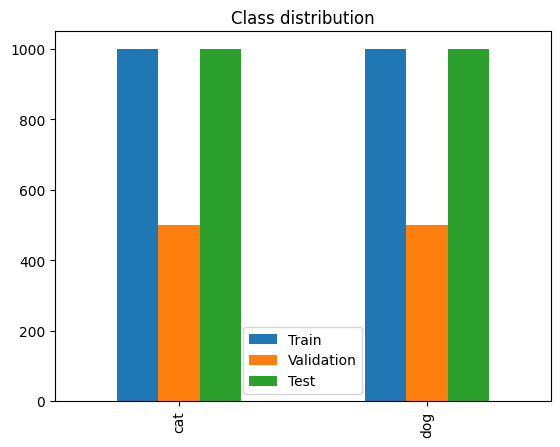

In [ ]:
# Plot the class distribution
plt.figure(figsize=(6, 6))
counts_df.plot(kind="bar")
plt.title("Class distribution")
plt.show()

### 2.2 Display sample images


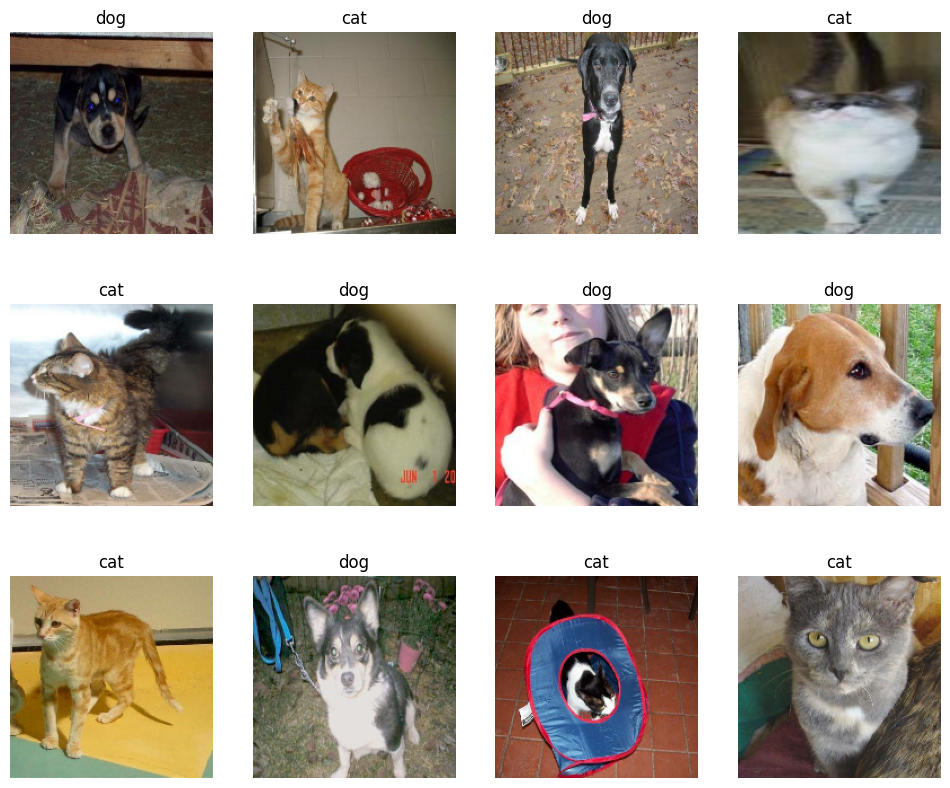

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

### 2.3 Image size and color channels


In [ ]:
# Get the first image from the training dataset
for images, labels in train_dataset.take(1):
    print(f"Image size: {images.shape[1:3]}")
    print(f"Image color channels: {images.shape[3]}")
    break

Image size: (180, 180)
Image color channels: 3


### 2.4 Data augmentation


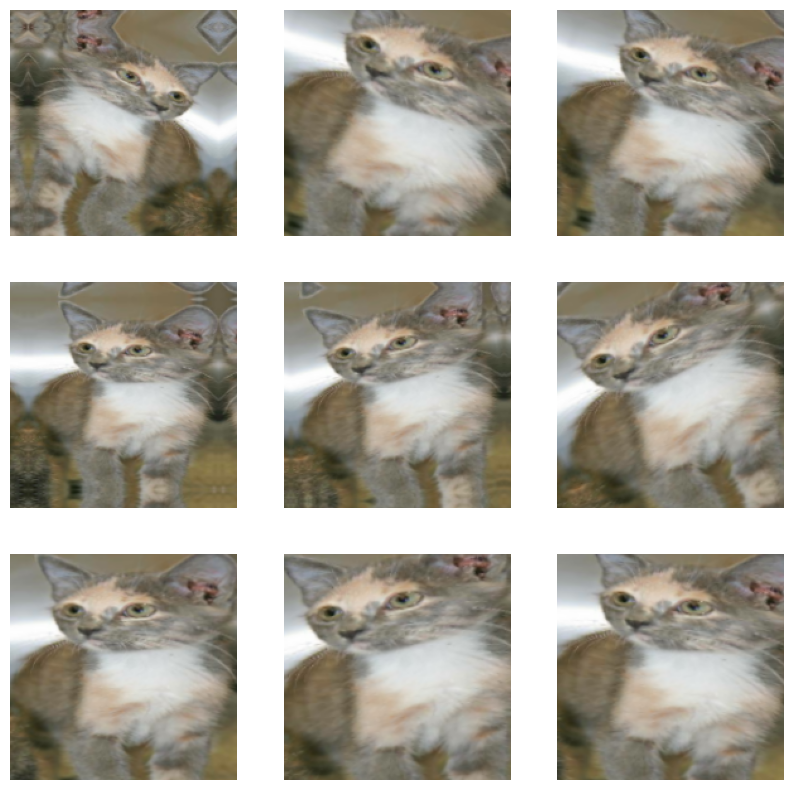

In [ ]:
from keras import layers
import keras

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Display augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 3. Training vanilla CNN model


Define a vanilla CNN model with data augmentation and dropout.


In [ ]:
def create_vanilla_cnn_model():
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)

    x = layers.Dense(256, activation="relu")(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [ ]:
vanilla_cnn_model = create_vanilla_cnn_model()
vanilla_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [ ]:
vanilla_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/vanilla_cnn_model.h5",
        save_best_only=True,
        monitor="val_loss",
    )
]

vanilla_history = vanilla_cnn_model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=vanilla_callbacks,
)

Epoch 1/5
63/63 [==============================] - 24s 369ms/step - loss: 0.7596 - accuracy: 0.4935 - val_loss: 0.6928 - val_accuracy: 0.5060
Epoch 2/5


/opt/homebrew/anaconda3/envs/foundations_tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 22s 345ms/step - loss: 0.7166 - accuracy: 0.5095 - val_loss: 0.6894 - val_accuracy: 0.5180
Epoch 3/5
63/63 [==============================] - 22s 341ms/step - loss: 0.7053 - accuracy: 0.5215 - val_loss: 0.6878 - val_accuracy: 0.6390
Epoch 4/5
63/63 [==============================] - 22s 356ms/step - loss: 0.6876 - accuracy: 0.5585 - val_loss: 0.6736 - val_accuracy: 0.5320
Epoch 5/5
63/63 [==============================] - 22s 349ms/step - loss: 0.7064 - accuracy: 0.6070 - val_loss: 0.6343 - val_accuracy: 0.6690


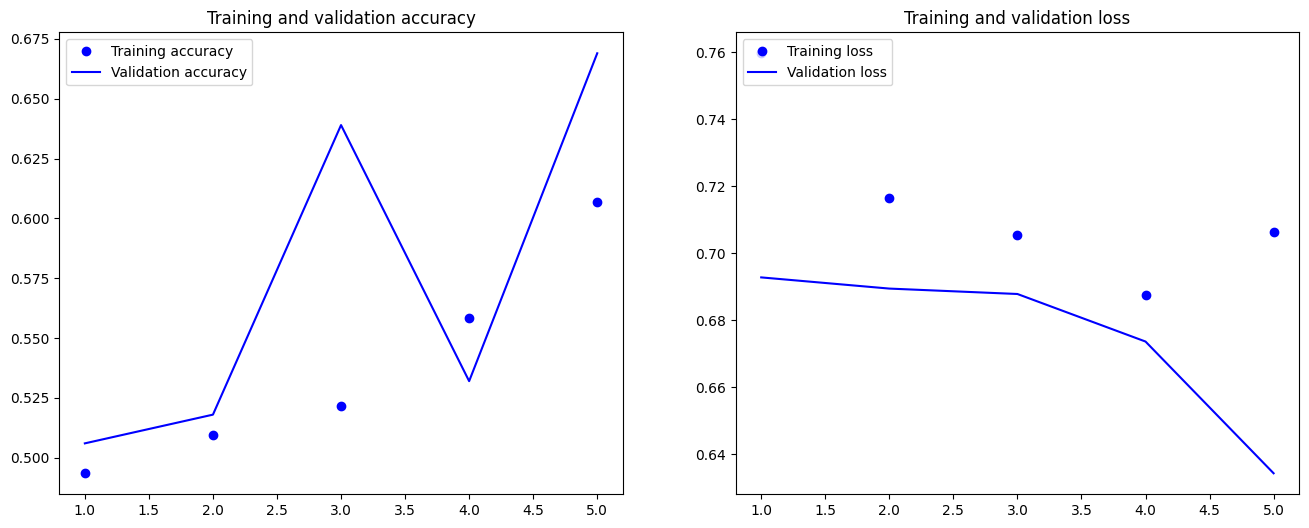

In [ ]:
def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(accuracy) + 1)

    # accuracy
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs_range, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend(loc="upper left")

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, "bo", label="Training loss")
    plt.plot(epochs_range, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend(loc="upper left")

    plt.show()


plot_history(vanilla_history)

## 4. Fine-tuning VGG16 model


Instantiate the VGG16 model with pre-trained ImageNet weights, remove the top layers.


In [ ]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Define a new model using VGG16 as the base, freezing all layers except the top four layers, and add a custom head for fine-tuning. Additionally, use data augmentation.


In [ ]:
def create_finetuned_model(conv_base):
    # Freeze all layers until the fourth from the last.
    conv_base.trainable = True
    for layer in conv_base.layers[:-4]:
        layer.trainable = False

    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), metrics=["accuracy"])

    return model

In [44]:
finetuned_model = create_finetuned_model(conv_base)
finetuned_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_8  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0   

In [45]:
finetuned_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/finetuned_vgg16_model.h5",
        save_best_only=True,
        monitor="val_loss",
    )
]

finetuned_history = finetuned_model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=finetuned_callbacks,
)

Epoch 1/5
34/63 [===============>..............] - ETA: 50s - loss: 0.8397 - accuracy: 0.4917

KeyboardInterrupt: 

In [ ]:
plot_history(finetuned_history)

## 5. Evaluate the models


In [ ]:
vanilla_model = keras.models.load_model("./models/vanilla_cnn_model.h5")
test_loss, test_acc = vanilla_model.evaluate(test_dataset)
print(f"Vanilla CNN model:")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

NameError: name 'test_model' is not defined

In [ ]:
finetuned_model = keras.models.load_model("./models/finetuned_vgg16_model.h5")
test_loss, test_acc = finetuned_model.evaluate(test_dataset)
print(f"Finetuned VGG16 model:")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

## 6. Conclusion
